<a id='start'></a>
# Описание проекта

Задание на проект: оптимизация маркетинговых затрат сервиса по продаже билетов.<br>

Данные с июня 2017 по конец мая 2018 года:
<ul>
 <li>лог сервера с данными о посещениях сайта</li>
 <li>выгрузка всех заказов за этот период</li>
 <li>статистика рекламных расходов</li>
</ul>

Информация для изучения:
<ul>
 <li>как люди пользуются продуктом</li>
 <li>когда они начинают покупать</li>
 <li>сколько денег приносит каждый клиент</li>
 <li>когда клиент окупается</li>
</ul>


### Проект выполнен по следующим шагам:
<a href='#step1'>Шаг 1. Загрузка данные и подготовка их к анализу</a><br>
<a href='#step2'>Шаг 2. Построение отчётов и расчёт метрик</a><br>
<a href='#step3'>Шаг 3. Вывод с рекомендацией маркетологам, куда и сколько им стоит вкладывать денег</a><br>


<a id='step1'></a>
## Шаг 1. Загрузка данных и подготовка их к анализу
<a href='#step11'>Описание данных</a><br>
<a href='#step12'>Таблица <i>visits</i></a><br>
<a href='#step13'>Таблица <i>orders</i></a><br>
<a href='#step14'>Таблица <i>costs</i></a><br>
<a href='#conclusion1'>Вывод 1</a><br>

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from datetime import  date
from scipy import stats as st
import seaborn as sns

#импорт необходимых библиотек

<a id='step11'></a>
### Описание данных:
<a href='#step12'>Таблица <i>visits</i></a> (лог сервера с информацией о посещениях сайта):
<ul>
 <li>Uid — уникальный идентификатор пользователя</li>
 <li>Device — категория устройства пользователя</li>
 <li>Start Ts — дата и время начала сессии</li>
 <li>End Ts — дата и время окончания сессии</li>
 <li>Source Id — идентификатор рекламного источника, из которого пришел пользователь</li>
</ul>

<a href='#step13'>Таблица <i>orders</i></a> (информация о заказах):
<ul>
 <li>Uid — уникальный id пользователя, который сделал заказ</li>
 <li>Buy Ts — дата и время заказа</li>
 <li>Revenue — выручка Яндекс.Афиши с этого заказа</li>
</ul>

<a href='#step14'>Таблица <i>costs</i></a> (информация о затратах на маркетинг):
<ul>
 <li>source_id — идентификатор рекламного источника</li>
 <li>dt — дата</li>
 <li>costs — затраты на этот рекламный источник в этот день</li>
</ul>

<a id='step12'></a>
### Таблица <i>visits</i>:

In [2]:
visits = pd.read_csv(r'/datasets/visits_log.csv')

In [3]:
display(visits.head(10))

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Для удобства польщования необходимо названия столбцов привести к нижнему регистру

In [4]:
visits.columns = map(str.lower, visits.columns)
#привожу названия столбцов к нижнему регистру

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end ts       359400 non-null object
source id    359400 non-null int64
start ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Требуется изменение типа данных для столбцов: <i>end ts<i> и <i>start ts</i> на формат даты.

In [6]:
visits['end ts'] = pd.to_datetime(visits['end ts']) #преобразую в формат даты

In [7]:
visits['start ts'] = pd.to_datetime(visits['start ts']) #преобразую в формат даты

In [8]:
print('Всего дубликатов:',visits.duplicated().sum()) #просмотр количества дубликатов

Всего дубликатов: 0


Для ознакомления с данными вывожу уникальные значения столбцов device и source id:

In [9]:
print(visits['device'].unique()) #список уникальных значений

['touch' 'desktop']


In [10]:
print(sorted(visits['source id'].unique())) #список уникальных значений

[1, 2, 3, 4, 5, 6, 7, 9, 10]


Пользователи совершают визиты с двух типов устройств: touch и desktop, совершают переходы с 10 нумерованных рекламных источников.

<a id='step13'></a>
### Таблица <i>orders</i>:
<a href='#step11'>Описание данных</a><br>

In [11]:
orders = pd.read_csv(r'/datasets/orders_log.csv')

In [12]:
display(orders.head(10))

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Для удобства польщования необходимо названия столбцов привести к нижнему регистру

In [13]:
orders.columns = map(str.lower, orders.columns)
#привожу названия столбцов к нижнему регистру

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Требуется изменение типа данных для столбца <i>buy ts</i> на формат даты.

In [15]:
orders['buy ts'] = pd.to_datetime(orders['buy ts']) #преобразую в формат даты

In [16]:
print('Всего дубликатов:',orders.duplicated().sum()) #просмотр количества дубликатов

Всего дубликатов: 0


Для ознакомления с данными вывожу информацию по столбцу <i>revenue</i>

In [17]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Имеются выбросы по минимальным и максимальным значениям, необходимо учесть при дальнейших исследованиях.

<a id='step14'></a>
### Таблица <i>costs</i>:
<a href='#step11'>Описание данных</a><br>

In [18]:
costs = pd.read_csv(r'/datasets/costs.csv')

In [19]:
display(costs.head(10))

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Требуется изменение типа данных для столбца <i>dt</i> на формат даты.

In [21]:
costs['dt'] = pd.to_datetime(costs['dt']) #преобразую в формат даты

In [22]:
print('Всего дубликатов:',costs.duplicated().sum()) #просмотр количества дубликатов

Всего дубликатов: 0


Для ознакомления с данными вывожу уникальные значения столбца source_id:

In [23]:
print(sorted(costs['source_id'].unique())) #список уникальных значений

[1, 2, 3, 4, 5, 9, 10]


Пользователи совершают переходы с 7 нумерованных рекламных источников (нумерация совпадает с источниками в visits)

Для ознакомления с данными вывожу информацию по столбцу <i>costs</i>

In [24]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Имеются выбросы по минимальным и максимальным значениям, необходимо учесть при дальнейших исследованиях.

<a id='conclusion1'></a>
### Вывод 1

Пользователи совершают визиты с двух типов устройств: touch и desktop, совершают переходы с 10 нумерованных рекламных источников.

В столбах:
<ul>
 <li>visits['end ts']</li>
 <li>visits['start ts']</li>
 <li>orders['buy ts']</li>
 <li>costs['dt']</li>
</ul>
Формат данных был изменён на datetime64[ns].<br>

В столбцах:
<ul>
 <li>orders['revenue']</li>
 <li>costs['costs']</li>
</ul>
Имеются выбросы по минимальным и максимальным значениям, необходимо учитывать при дальнейших исследованиях.<br>

Во всех датасетах нет дубликатов.


<a id='step2'></a>
## Шаг 2. Построение отчётов и расчёт метрик
<a href='#step21'>2.1 Продукт</a>
<ul>
 <li><a href='#step211'>Сколько людей пользуются в день?</a></li>
 <li><a href='#step2111'>Сколько людей пользуются в неделю?</a></li>
 <li><a href='#step2112'>Сколько людей пользуются в месяц?</a></li>
 <li><a href='#step212'>Сколько сессий в день?</a></li>
 <li><a href='#step213'>Сколько длится одна сессия?</a></li>
 <li><a href='#step214'>Как часто люди возвращаются?</a></li>
 <li><a href='#step215'>Вывод (Продукт)</a></li>
</ul>

<a href='#step22'>2.2 Продажи</a>
<ul>
 <li><a href='#step221'>Когда люди начинают покупать?</a></li>
 <li><a href='#step222'>Сколько раз покупают за период?</a></li>
 <li><a href='#step223'>Какой средний чек?</a></li>
 <li><a href='#step224'>Сколько денег приносят? (LTV)</a></li>
 <li><a href='#step225'>Вывод (Продажи)</a></li>
</ul>

<a href='#step23'>2.3 Маркетинг</a>
<ul>
 <li><a href='#step231'>Сколько денег потратили всего?</a></li>
 <li><a href='#step232'>Сколько денег потратили на каждый источник?</a></li>
 <li><a href='#step233'>Сколько денег потратили по времени?</a></li>
 <li><a href='#step234'>Сколько стоило привлечение одного покупателя из каждого источника?</a></li>
 <li><a href='#step235'>На сколько окупились расходы? (ROI)</a></li>
 <li><a href='#step236'>Вывод (Маркетинг)</a></li>
</ul>

<a id='step21'></a>
### 2.1 Продукт

Для расчёта показателей дополняю таблицу следубщими столбцами:
<ul>
 <li><i>ts time</i> - продолжительность сессии</li>
 <li><i>ts day</i> - дата сессии (в формате гггг-мм-дд)</li>
 <li><i>ts week</i> - неделя сессии</li>
 <li><i>ts month</i> - месяц сессии</li>
 <li><i>ts year</i> - год сессии</li>
</ul>

In [25]:
visits['ts time'] = ((visits['end ts']-visits['start ts'])/ np.timedelta64(1, 's')).astype(int)
#определяю продолжительность сессии и преобразую в секундный целочисленный формат

In [26]:
visits['ts day'] = visits['start ts'].dt.floor('1D') #определяю день сессии

In [27]:
visits['ts week'] = visits['start ts'].dt.week #определяю неделю сессии

In [28]:
visits['ts month'] = visits['start ts'].dt.month #определяю месяц сессии

In [29]:
visits['ts year'] = visits['start ts'].dt.year #определяю год сессии

In [30]:
display(visits.head(10))

,device,end ts,source id,start ts,uid,ts time,ts day,ts week,ts month,ts year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,52,12,2017
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,60,2017-09-03,35,9,2017
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,3360,2018-01-30,5,1,2018
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,60,2017-11-05,44,11,2017
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,180,2017-07-19,29,7,2017
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,60,2017-11-08,45,11,2017


В датасете данные софрмированы по одному году, однако необходимо учитывать год для более последовательного решения задачи.

<a href='#step2'>Вверх</a><br>
<a id='step211'></a>
#### Сколько людей пользуются в день?

In [31]:
DAU = visits.groupby('ts day').agg({'uid':'nunique'}).mean().astype(int)
print('Среднее количество пользователей в день (DAU):', DAU[0])
#группирую по дате и рассчитываю среднее количество пользователей в день

Среднее количество пользователей в день (DAU): 907


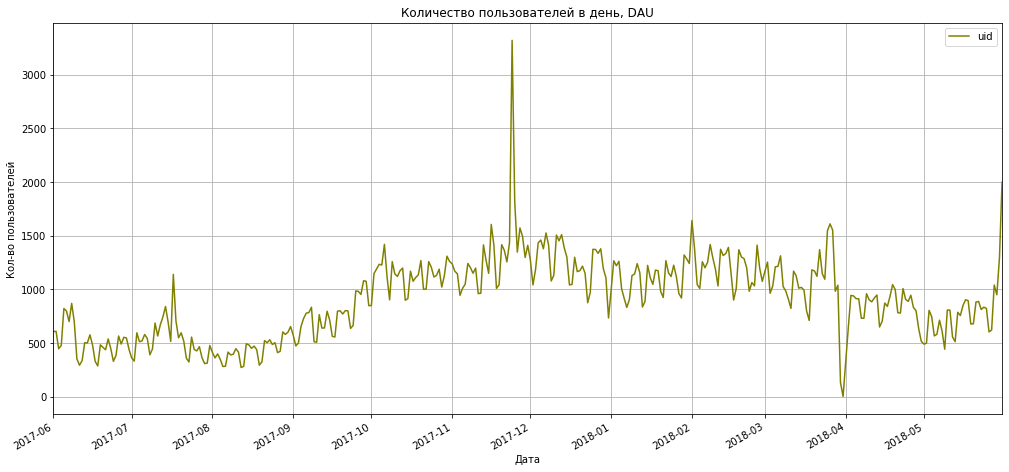

In [32]:
visits.groupby('ts day').agg({'uid':'nunique'}).plot(figsize = (17,8), grid=True, color='olive')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата')
plt.title('Количество пользователей в день, DAU')
plt.show()

Количество пользователей в день варьируется в среднем от 500 до 1500 человек, имеются незначительные выбросы.<br>
Наблюдаю рост числа пользователей с 09.2017 и снижение с 04.2018. Это объясняется сезонностью, т.к. в летнее время число мероприятий и спрос на них снижается.

In [33]:
visits_pd_device = visits.pivot_table(index='ts day', columns='device', values='uid', aggfunc='nunique').mean().reset_index()

Формирую таблицу в которой по каждому дню и типу устройства посчитано количество уникальных пользователей, затем рассчитано среднее значение по этим данным.

In [34]:
visits_pd_device.columns = ['device','users'] #переименовываю столбцы
visits_pd_device['users'] = visits_pd_device['users'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

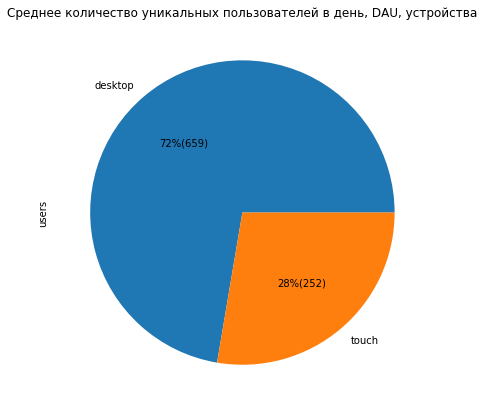

In [35]:
visits_pd_device['users'].plot(figsize = (7,7), legend=False, title='Среднее количество уникальных пользователей в день, DAU, устройства',
        kind='pie', labels=visits_pd_device['device'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pd_device['users'].sum()));


С desktop устройств в день сервисом пользуется в среднем в три раза больше пользователей, чем с touch.

In [36]:
visits_pd_source = visits.pivot_table(index='ts day', columns='source id', values='uid', aggfunc='nunique').mean().reset_index()

Формирую таблицу в которой по каждому дню и рекламному источнику посчитано количество уникальных пользователей, затем рассчитано среднее значение по этим данным.

In [37]:
visits_pd_source.columns = ['source','users'] #переименовываю столбцы
visits_pd_source['users'] = visits_pd_source['users'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

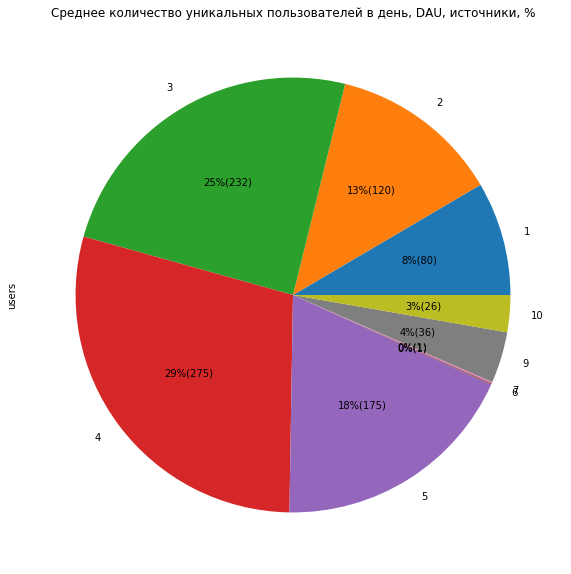

In [38]:
visits_pd_source['users'].plot(figsize = (10,10), legend=False, title='Среднее количество уникальных пользователей в день, DAU, источники, %',
        kind='pie', labels=visits_pd_source['source'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pd_source['users'].sum()));


Самые эффективные рекламные источники по среднему количеству пользователей в день: 4, 3 и 5. Источники 6,7 - с нулевой эффективностью.

<a href='#step2'>Вверх</a><br>
<a id='step2111'></a>
#### Сколько людей пользуются в неделю?

In [39]:
WAU = visits.groupby(['ts year','ts week']).agg({'uid':'nunique'}).mean().astype(int)
print('Среднее количество пользователей в неделю (WAU):',WAU[0])
#группирую по дате и рассчитываю среднее количество пользователей в неделю

Среднее количество пользователей в неделю (WAU): 5716


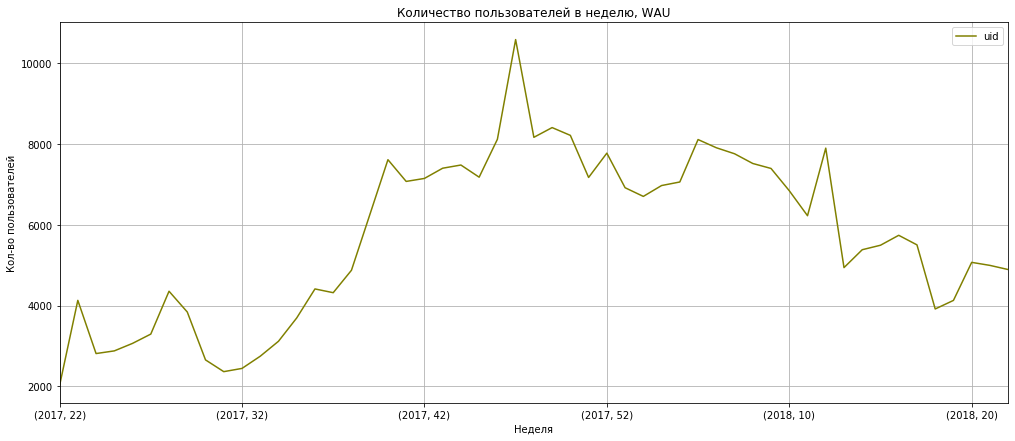

In [40]:
visits.groupby(['ts year','ts week']).agg({'uid':'nunique'}).plot(figsize = (17,7), grid=True, color='olive')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Неделя')
plt.title('Количество пользователей в неделю, WAU')
plt.show();

Количество пользователей в неделю варьируется в среднем от 3000 до 7000 человек, имеются незначительные выбросы.<br>
Наблюдаю рост числа пользователей с 37й недели 2017 года и снижение с 15 недели 2018 года. Это объясняется сезонностью, т.к. в летнее время число мероприятий и спрос на них снижается.

In [41]:
visits_pw_device = visits.pivot_table(index=['ts year','ts week'], columns='device', values='uid', aggfunc='nunique').mean().reset_index()

Формирую таблицу в которой по каждой неделе и типу устройства посчитано количество уникальных пользователей, затем рассчитано среднее значение по этим данным.

In [42]:
visits_pw_device.columns = ['device','users'] #переименовываю столбцы
visits_pw_device['users'] = visits_pw_device['users'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

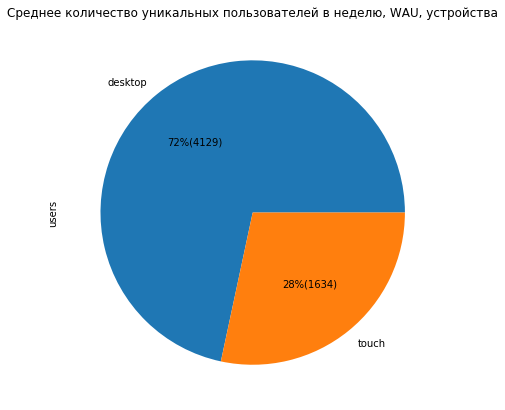

In [43]:
visits_pw_device['users'].plot(figsize = (7,7), legend=False, title='Среднее количество уникальных пользователей в неделю, WAU, устройства',
        kind='pie', labels=visits_pw_device['device'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pw_device['users'].sum()));


С desktop устройств в неделю сервисом пользуется в среднем в три раза больше пользователей, чем с touch.

In [44]:
visits_pw_source = visits.pivot_table(index=['ts year','ts week'], columns='source id', values='uid', aggfunc='nunique').mean().reset_index()

Формирую таблицу в которой по каждой неделе и рекламному источнику посчитано количество уникальных пользователей, затем рассчитано среднее значение по этим данным.

In [45]:
visits_pw_source.columns = ['source','users'] #переименовываю столбцы
visits_pw_source['users'] = visits_pw_source['users'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

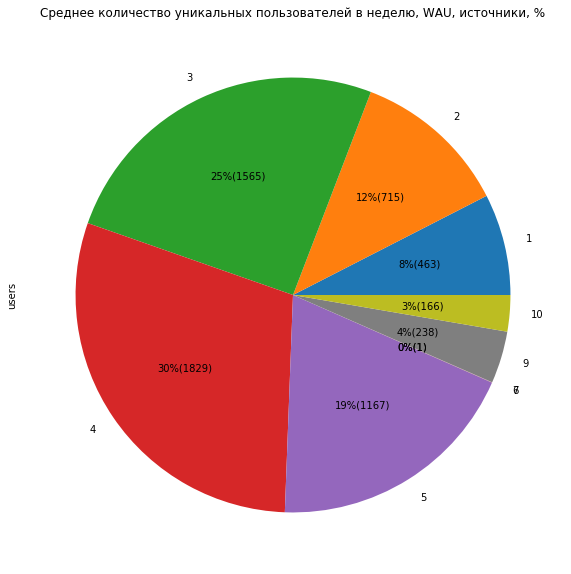

In [46]:
visits_pw_source['users'].plot(figsize = (10,10), legend=False, title='Среднее количество уникальных пользователей в неделю, WAU, источники, %',
        kind='pie', labels=visits_pw_source['source'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pw_source['users'].sum()));

Самые эффективные рекламные источники по среднему количеству пользователей в день: 4, 3 и 5. Источники 6,7 - с нулевой эффективностью.

<a href='#step2'>Вверх</a><br>
<a id='step2112'></a>
#### Сколько людей пользуются в месяц?

In [47]:
MAU = visits.groupby(['ts year','ts month']).agg({'uid':'nunique'}).mean().astype(int)
print('Среднее количество пользователей в месяц (MAU):', MAU[0])
#группирую по дате и рассчитываю среднее количество пользователей в месяц

Среднее количество пользователей в месяц (MAU): 23228


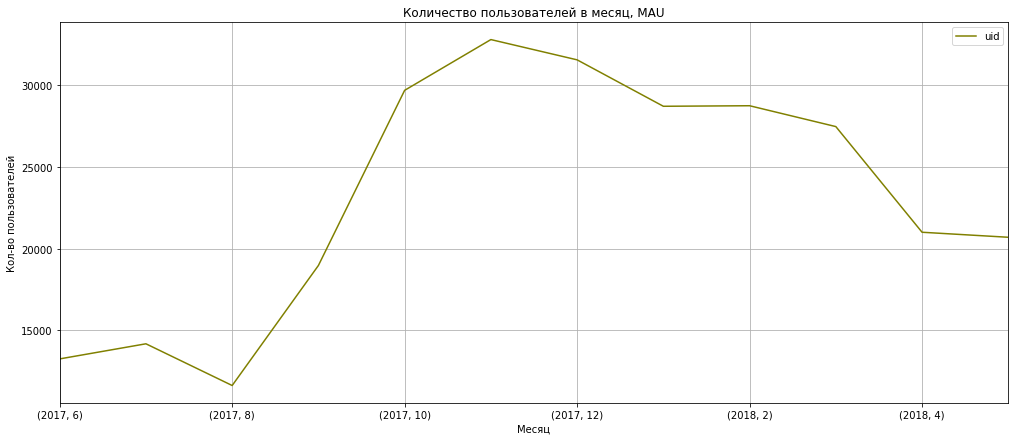

In [48]:
visits.groupby(['ts year','ts month']).agg({'uid':'nunique'}).plot(figsize = (17,7), grid=True, color='olive')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Месяц')
plt.title('Количество пользователей в месяц, MAU')
plt.show();

Количество пользователей в месяц варьируется в среднем от 15000 до 30000 человек, имеются незначительные выбросы.<br>
Наблюдаю рост числа пользователей с 08.2017 и снижение с 03.2018. Это объясняется сезонностью, т.к. в летнее время число мероприятий и спрос на них снижается.

In [49]:
visits_pm_device = visits.pivot_table(index=['ts year','ts month'], columns='device', values='uid', aggfunc='nunique').mean().reset_index()

Формирую таблицу в которой по каждому месяцу и типу устройства посчитано количество уникальных пользователей, затем рассчитано среднее значение по этим данным.

In [50]:
visits_pm_device.columns = ['device','users'] #переименовываю столбцы
visits_pm_device['users'] = visits_pm_device['users'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

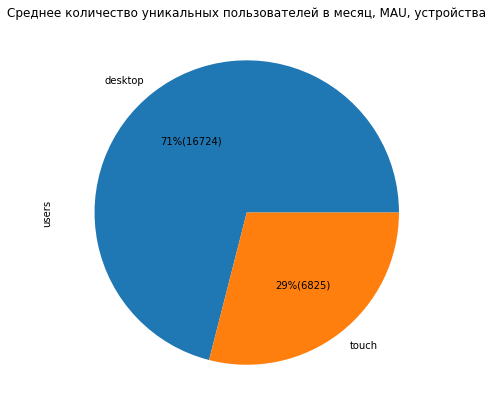

In [51]:
visits_pm_device['users'].plot(figsize = (7,7), legend=False, title='Среднее количество уникальных пользователей в месяц, MAU, устройства',
        kind='pie', labels=visits_pm_device['device'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pm_device['users'].sum()));


С desktop устройств в месяц сервисом пользуется в среднем в три раза больше пользователей, чем с touch.

In [52]:
visits_pm_source = visits.pivot_table(index=['ts year','ts month'], columns='source id', values='uid', aggfunc='nunique').mean().reset_index()

Формирую таблицу в которой по каждому месяцу и рекламному источнику посчитано количество уникальных пользователей, затем рассчитано среднее значение по этим данным.

In [53]:
visits_pm_source.columns = ['source','users'] #переименовываю столбцы
visits_pm_source['users'] = visits_pm_source['users'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

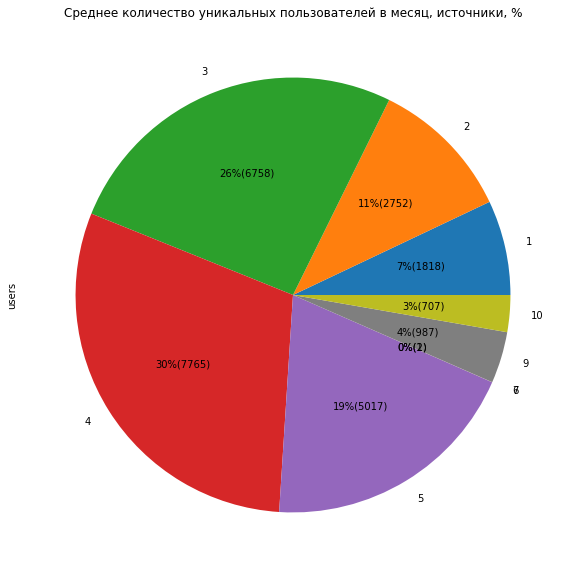

In [54]:
visits_pm_source['users'].plot( figsize = (10,10), legend=False, title='Среднее количество уникальных пользователей в месяц, источники, %',
        kind='pie', labels=visits_pw_source['source'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pm_source['users'].sum()));

Самые эффективные рекламные источники по среднему количеству пользователей в месяц: 4, 3 и 5. Источники 6,7 - с нулевой эффективностью.

<a href='#step2'>Вверх</a><br>
<a id='step212'></a>
#### Сколько сессий в день?

In [55]:
average_sessions = visits.groupby('ts day').agg({'uid':'count'}).mean().astype(int)
print('Среднее количество пользователей в день:',average_sessions[0])
#группирую по дате и рассчитываю среднее количество сессий в день

Среднее количество пользователей в день: 987


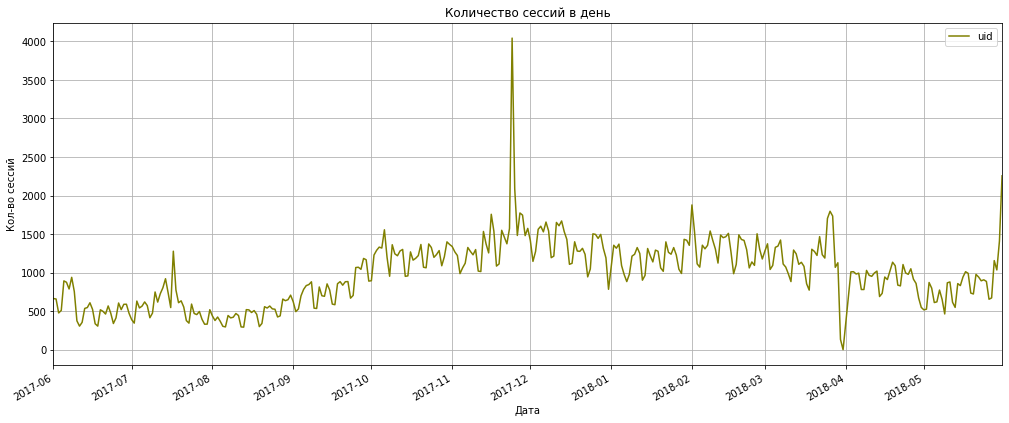

In [56]:
visits.groupby(['ts day']).agg({'uid':'count'}).plot(figsize = (17,7), grid=True, color='olive')
plt.ylabel('Кол-во сессий')
plt.xlabel('Дата')
plt.title('Количество сессий в день')
plt.show();

Количество сессий в день варьируется в среднем от 500 до 1500, имеются незначительные выбросы.<br>
График кореллирует с графиком количества пользователей в день.<br>
Наблюдаю рост числа сессий с 09.2017 и снижение с 04.2018. Это также объясняется сезонностью, т.к. в летнее время число мероприятий и спрос на них снижается. 

In [57]:
sessions_one_user = visits.groupby('ts day').agg({'uid':'nunique', 'start ts':'count'}).reset_index()
# формирую таблицу, сгрупированную по дате, с количеством пользователей в день и количеством сессий
sessions_one_user['spu'] = sessions_one_user['start ts'] / sessions_one_user['uid']
# рассчитываю показатель количества сессий на одного пользователя в день


Также рассчитываю число сессий в день на одного пользователя.

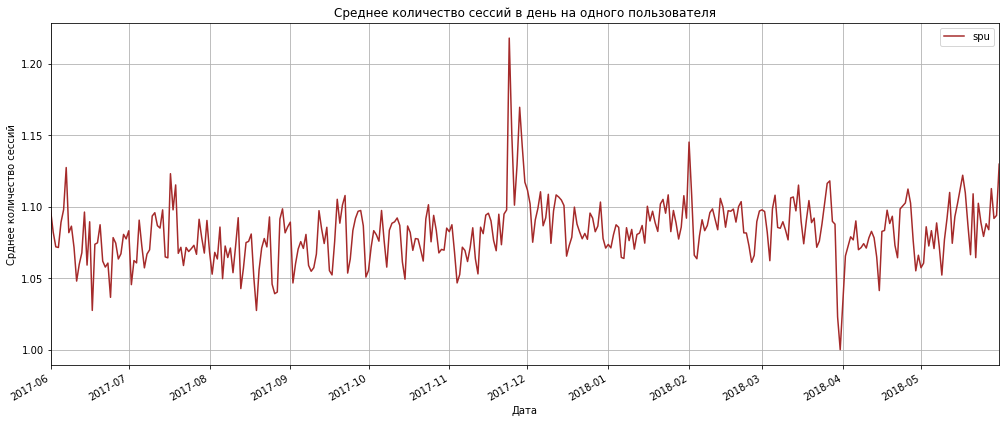

In [58]:
sessions_one_user.groupby('ts day').agg({'spu':'mean'}).plot(figsize = (17,7), grid=True, color='brown')
plt.ylabel('Срднее количество сессий')
plt.xlabel('Дата')
plt.title('Среднее количество сессий в день на одного пользователя')
plt.show();

Количество сессий на одного пользователя в пределах 1.05 - 1.10. В декабре 2017 наблюдаю рост числа сессий до 1.2

In [59]:
average_spu = sessions_one_user.groupby('ts day').agg({'spu':'mean'}).mean()
#рассчитываю среднее количество сессий на одного пользователя
print('Среднее количество сессий в день на одного пользователя: {:.2f}'.format(average_spu[0]))

Среднее количество сессий в день на одного пользователя: 1.08


In [60]:
session_device = visits.pivot_table(index='ts day', columns='device', values='uid', aggfunc='count').mean().reset_index()

Формирую таблицу в которой по каждому дню и типу устройства посчитано количество сессий, затем рассчитано среднее значение по этим данным.

In [61]:
session_device.columns = ['device','sessions'] #переименовываю столбцы
session_device['sessions'] = session_device['sessions'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

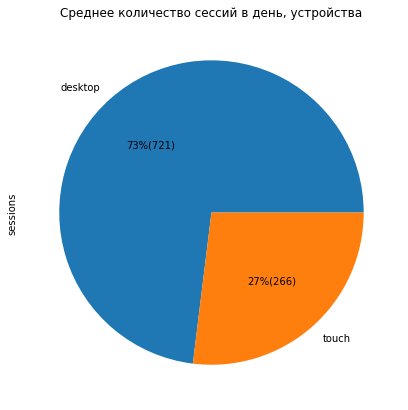

In [62]:
session_device['sessions'].plot(figsize = (7,7), legend=False, title='Среднее количество сессий в день, устройства',
        kind='pie', labels=session_device['device'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*session_device['sessions'].sum()));

С desktop устройств в день сервисом совершается в среднем в три раза больше сессий, чем с touch.

In [63]:
session_source = visits.pivot_table(index='ts day', columns='source id', values='uid', aggfunc='count').mean().reset_index()

Формирую таблицу в которой по каждому дню и рекламному источнику посчитано количество сессий, затем рассчитано среднее значение по этим данным.

In [64]:
session_source.columns = ['source','sessions'] #переименовываю столбцы
session_source['sessions'] = session_source['sessions'].astype(int) #изменяю тип данных

Переименовываю столбцы и привожу данные по числу пользователей к целочисленным.

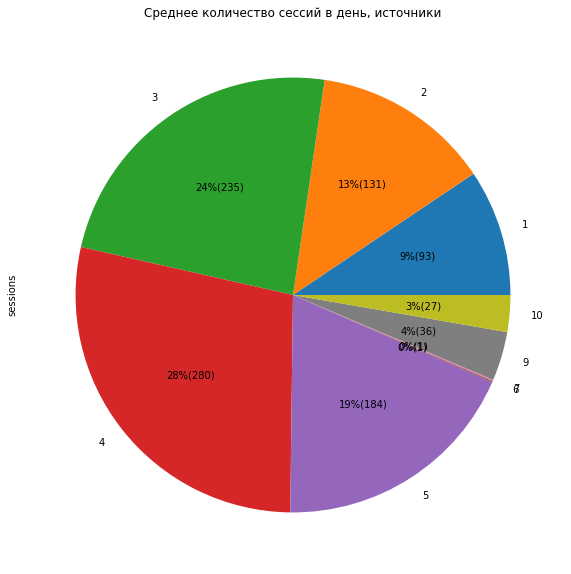

In [65]:
session_source['sessions'].plot(figsize = (10,10), legend=False, title='Среднее количество сессий в день, источники',
        kind='pie', labels=session_source['source'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*session_source['sessions'].sum()));

Самые эффективные рекламные источники по среднему количеству сессий в месяц: 4, 3 и 5. Источники 6,7 - с нулевой эффективностью.

<a href='#step2'>Вверх</a><br>
<a id='step213'></a>
#### Сколько длится одна сессия?

In [66]:
visits['ts time'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: ts time, dtype: float64

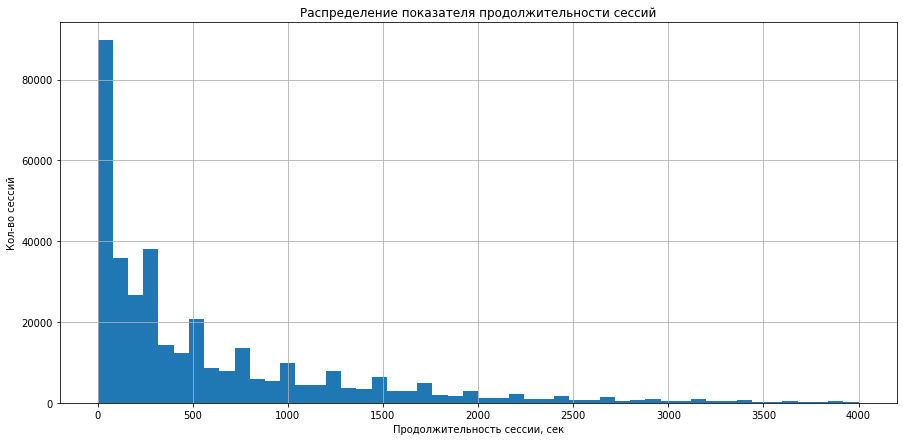

In [67]:
visits['ts time'].hist(figsize=(15, 7), range=(0, 4000), bins=50)
#строю гистограмму распределения продолжительности сессии
plt.ylabel('Кол-во сессий')
plt.xlabel('Продолжительность сессии, сек')
plt.title('Распределение показателя продолжительности сессий')
plt.show();

С учётом ненормального распределения данных и выбросов необходимо использовать для анализа медианное значение.

In [68]:
session_duration_mean = (visits['ts time']).mean()
#рассчитываю среднюю продолжительность сессии
print('Средняя продолжительность сессии:',session_duration_mean)

Средняя продолжительность сессии: 643.0256872565387


In [69]:
session_duration = (visits['ts time']).median()
#рассчитываю медианную продолжительность сессии
print('Медианная продолжительность сессии:',session_duration)

Медианная продолжительность сессии: 300.0


In [70]:
session_duration_device = visits.groupby('device').agg({'ts time':'median'}).reset_index()

Создаю датафрейм, в котором группирую сессии по типу устройства и рассчитываю медианную продолжительность одной сесии.

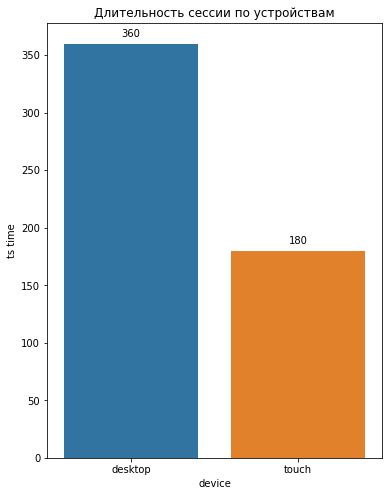

In [71]:
plt.figure(figsize=(6, 8)) #строю график
splot = sns.barplot(data=session_duration_device, x = 'device', y = 'ts time', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Длительность сессии по устройствам');

Сессия с устройства desctop длится в 2 раза дольше, чем сессия с устройства touch.

In [72]:
session_duration_source = visits.groupby('source id').agg({'ts time':'median'}).reset_index()

Создаю датафрейм, в котором группирую сессии по источнику и рассчитываю медианную продолжительность одной сесии.

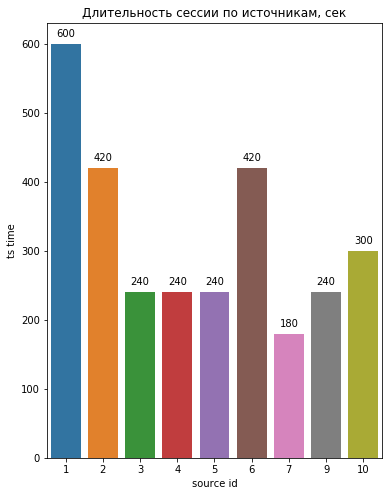

In [73]:
plt.figure(figsize=(6, 8)) #строю график
splot = sns.barplot(data=session_duration_source, x = 'source id', y = 'ts time', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Длительность сессии по источникам, сек');

Самые продолжительные сессии с источников 6, 1 и 2.
При этом с источника 3, одного из лидеров по количеству пользователей, сессия одна из самых коротких.

<a href='#step2'>Вверх</a><br>
<a id='step214'></a>
#### Как часто люди возвращаются?

Необходимо рассчитать Retention Rate

In [74]:
first_activity_date = visits.groupby(['uid'])['start ts'].min().reset_index()

Фиксирую дату первой активности пользователя.

In [75]:
first_activity_date.columns = ['uid','first activity date'] #переименовываю колонки

In [76]:
visits = visits.merge(first_activity_date, on='uid', how='left')

Добавляю информацию о первой активности пользователя в датафрейм visits.

In [77]:
visits['first activity month'] = visits['first activity date'].astype('datetime64[M]') #определяю месяц первой активности

Добавляю столбцы с месяцом и годом первой активности пользователя

In [78]:
visits['cohort lifetime'] = visits['start ts'] - visits['first activity date']

Добавляю столбец с временем жизни клиента (lifetime) для каждой строки.

In [79]:
visits['cohort lifetime'] = visits['cohort lifetime'] / np.timedelta64(1,'M')
visits['cohort lifetime'] = visits['cohort lifetime'].astype('int')

Преобразую данные о периоде активности клиента в целочисленные (еденица измерения - месяцы).

In [80]:
cohorts = visits.groupby(['first activity month','cohort lifetime']).agg({'uid':'nunique'}).reset_index()

Формирую датасет с когортами (группировка по дате и времени жизни клиента, подсчёт количества уникальных пользователей).

In [81]:
initial_users_count = cohorts[cohorts['cohort lifetime'] == 0][['first activity month','uid']]
#сортирую только нулевые (первые) когорты, сохраняю столбца с годом, месяцем и количеством уникальных пользователей

Формирую датасет с информацией об исходном количестве пользователей в когорте.

In [82]:
initial_users_count = initial_users_count.rename(columns={'uid':'first month users'})

Переименовываю столбец с количеством пользователей для корректного merge.

In [83]:
cohorts = cohorts.merge(initial_users_count,on='first activity month')

Добавляю в датасет cohorts информацию об исходном количестве пользователей в когорте.

In [84]:
cohorts= cohorts.rename(columns={'uid':'current users'})

Переименовываю столбец с количеством пользователей для корректного отображения.

In [85]:
cohorts['retention'] = cohorts['current users']/cohorts['first month users']

Добавляю столбец с рассчётом коэффициента удержания.

In [86]:
retention_pivot = cohorts.pivot_table(index='first activity month',columns='cohort lifetime',values='retention',aggfunc='sum')

Создаю сводную таблицу с RR по когортам.

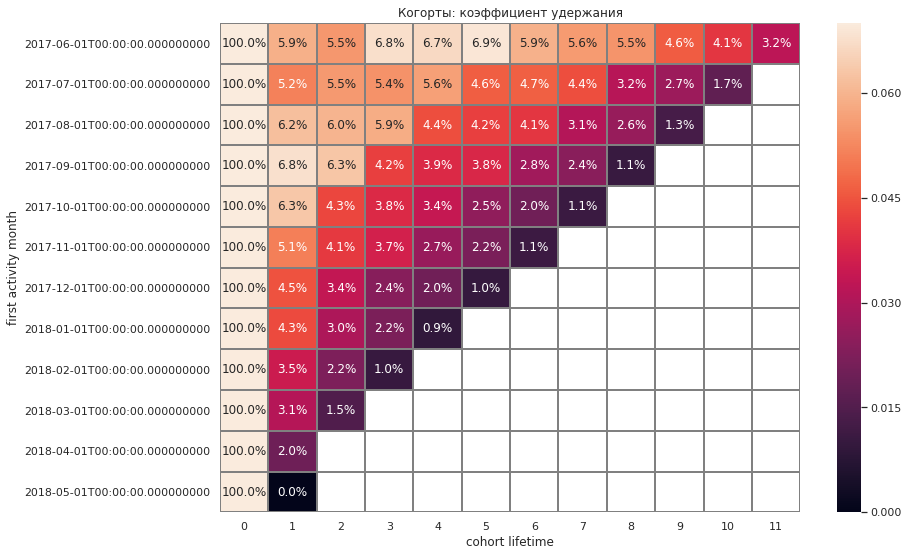

In [87]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Когорты: коэффициент удержания')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',vmin=0, vmax=0.07);


Самый высокий коэффициент удержания у когорт июня-августа 2017 года.<br>
А когорты июня 2017 года наблюдается рост возврата пользователей, возможно, это связано с новогодними активностями.

<a href='#step2'>Вверх</a><br>
<a id='step215'></a>
### Вывод (Продукт)

##### Сколько людей пользуются сервисом:

Средний показатель:<br>
<ul>
 <li>В день: 907 человек</li>
 <li>В неделю: 5716 человек</li>
 <li>В месяц: 23228 человек</li>
</ul>
По типу устройства: с устройств desktop 72%, с устройств touch - 28% <br>
По рекламному источнику: самые эффективные источники 4,3,5, а источники 6,7 - с нулевой эффективностью.

##### Сколько сессий в день:
Средний показатель: 987 сессий в день.<br>
Среднее количество сессий в день на одного пользователя: 1.08<br>
По типу устройства: с устройств desktop 73%, с устройств touch - 27% <br>
По рекламному источнику: самые эффективные источники 4,3,5, а источники 6,7 - с нулевой эффективностью.

Наблюдаю рост числа пользователей и пользовательских сессий с 09.2017 и снижение с 04.2018. Это объясняется сезонностью, т.к. в летнее время число мероприятий и спрос на них снижается, в зимнее время наоборот растёт.

##### Сколько длится одна сессия:
Медианная продолжительность сессии: 300 секунд<br>
По типу устройства, медианное значение: с устройств desktop 360 секунды, с устройств touch - 180 секунд.<br>
Самые продолжительные сессии с источников 6, 1 и 2, а с источника 3 одна из самых коротких.

##### Как часто люди возвращаются:
Самый высокий коэффициент удержания у когорт июня-августа 2017 года.<br>
А когорты июня 2017 года наблюдается рост возврата пользователей, возможно, это связано с новогодними активностями.<br>
Необходимо запросить дополнительную информаци, проводились ли какие-то маркетинговые мероприятия для старых пользоваталей в этот период.

<a href='#step2'>Вверх</a><br>
<a id='step22'></a>
### 2.2 Продажи

<a href='#step2'>Вверх</a><br>
<a id='step221'></a>
#### Когда люди начинают покупать?

In [88]:
orders = orders.merge(first_activity_date, on='uid', how='left')

Добавляю информацию о первой активности пользователя в датафрейм orders.

In [89]:
first_order_date = orders.groupby(['uid'])['buy ts'].min().reset_index()

Фиксирую дату первой покупки пользователя.

In [90]:
first_order_date.columns = ['uid','first order date'] #переименовываю колонки

In [91]:
orders = orders.merge(first_order_date, on='uid', how='left')

Добавляю информацию о первой покупке пользователя в датафрейм orders.

In [92]:
orders['order time'] = orders['first order date'] - orders['first activity date']

In [93]:
orders['order time']=orders['order time'].astype('timedelta64[D]')

Рассчитываю количество времени, которое проходит от первой активности до первой покупки в днях, для каждой строки.

In [94]:
print(
    'Среднее время первой покупки после первого взаимодействия: {:.0f}'.format(
    orders.groupby('uid')['order time'].min().mean()),'дней')

Среднее время первой покупки после первого взаимодействия: 17 дней


In [95]:
print(
    'Медианное время первой покупки после первого взаимодействия: {:.0f}'.format(
    orders.groupby('uid')['order time'].min().median()),'дней')

Медианное время первой покупки после первого взаимодействия: 0 дней


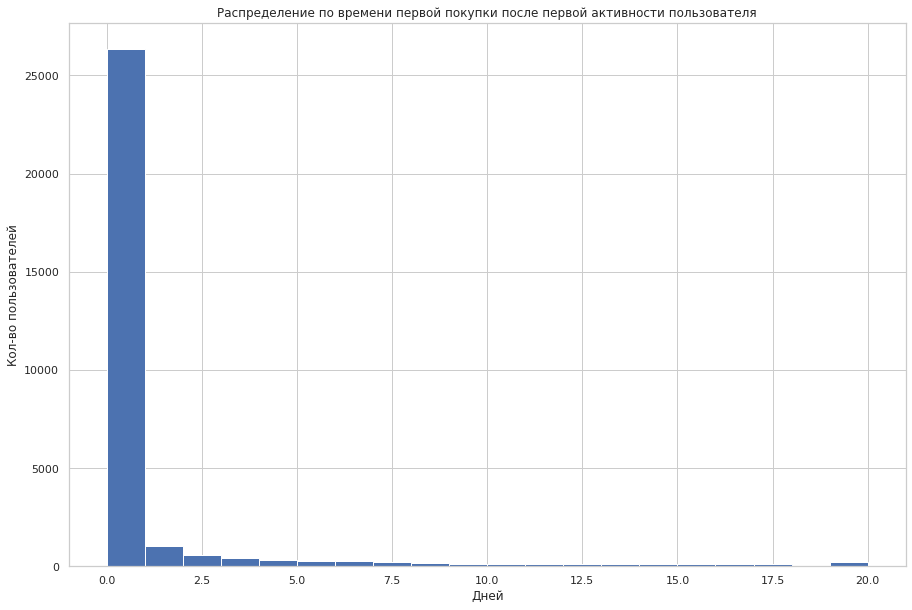

In [96]:
orders.groupby('uid').agg({'order time':'min'}).hist(figsize=(15, 10), range=(0, 20), bins=20)
#строю гистограмму распределения количества покупок по времени от первой активности
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дней')
plt.title('Распределение по времени первой покупки после первой активности пользователя')
plt.show();

Поскольку распределение не нормальное, считаю корректным использование медианного значения 0 дней, что подтверждается графиком.

<a href='#step2'>Вверх</a><br>
<a id='step222'></a>
#### Сколько раз покупают за период?

In [97]:
orders['buy ts day'] = orders['buy ts'].astype('datetime64[D]') #определяю день покупки

In [98]:
orders['buy ts month'] = orders['buy ts'].astype('datetime64[M]') #определяю месяц покупки

In [99]:
orders['buy ts week'] = orders['buy ts'].astype('datetime64[W]') #определяю неделю покупки

In [100]:
print(
    'Среднее количество покупок в день: {:.0f}'.format(
    orders.groupby('buy ts day')['uid'].count().mean()))

Среднее количество покупок в день: 139


In [101]:
print(
    'Среднее количество покупок в неделю: {:.0f}'.format(
    orders.groupby('buy ts week')['uid'].count().mean()))

Среднее количество покупок в неделю: 951


In [102]:
print(
    'Среднее количество покупок в месяц: {:.0f}'.format(
    orders.groupby('buy ts month')['uid'].count().mean()))

Среднее количество покупок в месяц: 3878


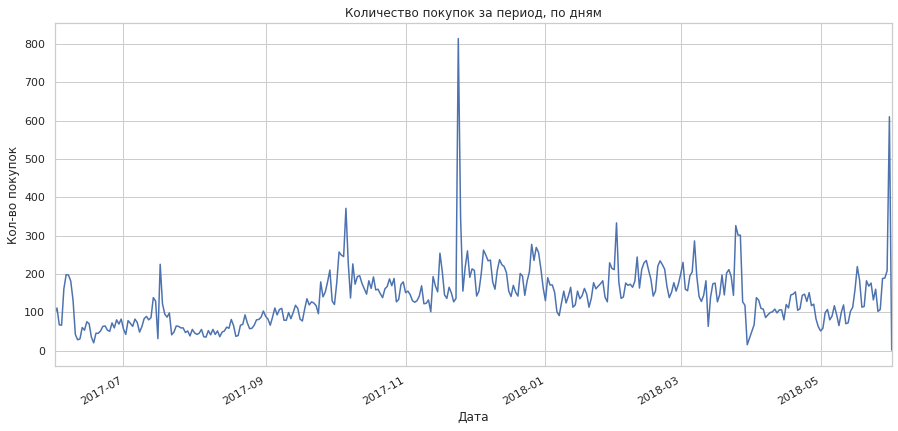

In [103]:
orders.groupby('buy ts day')['uid'].count().plot(figsize=(15, 7))
#строю график количества покупок по дням
plt.ylabel('Кол-во покупок')
plt.xlabel('Дата')
plt.title('Количество покупок за период, по дням')
plt.show();

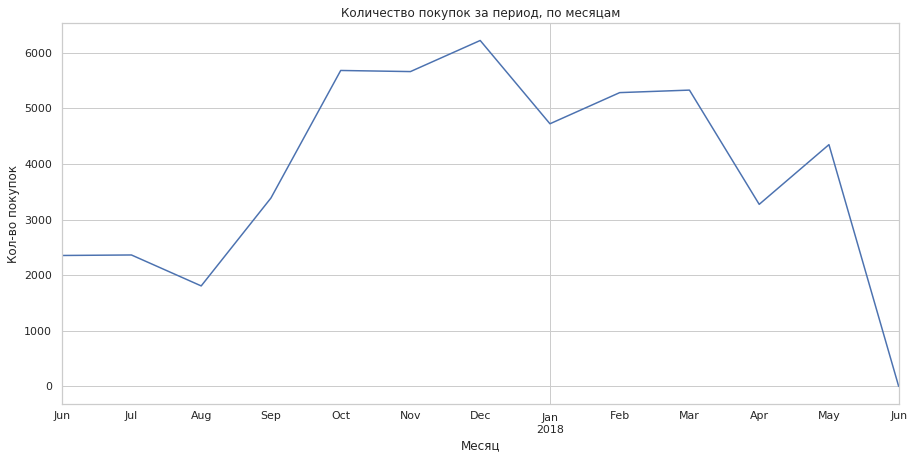

In [104]:
orders.groupby('buy ts month')['uid'].count().plot(figsize=(15, 7))
#строю график количества покупок по месяцам
plt.ylabel('Кол-во покупок')
plt.xlabel('Месяц')
plt.title('Количество покупок за период, по месяцам')
plt.show()

По графику четко прослеживается сезонность с сентября по май, максимальное количество покупок за период в октябре-декабре, связано в том числе с новогодними прадниками.

In [105]:
orders['first order month'] = orders['first order date'].astype('datetime64[M]')

Добавляю столбец с месяцем первой покупки.

In [193]:
orders_cohorts_month = orders.groupby(['first order month','buy ts month']).agg({'revenue':'count', 'uid':'nunique'}).reset_index()
orders_cohorts_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 4 columns):
first order month    79 non-null datetime64[ns]
buy ts month         79 non-null datetime64[ns]
revenue              79 non-null int64
uid                  79 non-null int64
dtypes: datetime64[ns](2), int64(2)
memory usage: 2.6 KB


In [194]:
orders_cohorts_month.rename(columns={'revenue': 'purchases'}, inplace=True) #переименовать столбец

In [195]:
orders_cohorts_month['orders per user'] = orders_cohorts_month['purchases']/orders_cohorts_month['uid'] #рассчитываю среднее

In [214]:
orders_cohorts_month['month'] = orders_cohorts_month['buy ts month']-orders_cohorts_month['first order month']
orders_cohorts_month['month'] = (orders_cohorts_month['month']/np.timedelta64(1, 'M')).astype(int)

In [215]:
display(orders_cohorts_month)

,first order month,buy ts month,purchases,uid,orders per user,month
0,2017-06-01,2017-06-01,2354,2023,1.163618,0
1,2017-06-01,2017-07-01,177,61,2.901639,0
2,2017-06-01,2017-08-01,174,50,3.480000,2
3,2017-06-01,2017-09-01,226,54,4.185185,3
4,2017-06-01,2017-10-01,292,88,3.318182,4
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,176,58,3.034483,2
75,2018-04-01,2018-04-01,2495,2276,1.096221,0
76,2018-04-01,2018-05-01,195,69,2.826087,0
77,2018-05-01,2018-05-01,3249,2988,1.087349,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 6 columns):
first order month    79 non-null datetime64[ns]
buy ts month         79 non-null datetime64[ns]
purchases            79 non-null int64
uid                  79 non-null int64
orders per user      79 non-null float64
month                79 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 3.8 KB


Группирую данные по когорте первого месяца покупки и месяцу совершения покупки, подсчитываю количество покупок за месяц.

In [223]:
orders_cohorts_month_pivot = orders_cohorts_month.pivot_table(
    index='first order month',columns='buy ts month',values='orders per user',aggfunc='mean').cumsum(axis=1).round(2)
display(orders_cohorts_month_pivot)

buy ts month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first order month,,,,,,,,,,,,,
2017-06-01,1.16,4.07,7.55,11.73,15.05,18.30,22.75,26.46,30.11,33.51,35.64,37.27,NaN
2017-07-01,NaN,1.14,3.06,5.17,6.79,8.26,10.42,12.11,13.39,14.77,15.87,17.90,NaN
2017-08-01,NaN,NaN,1.12,2.98,4.87,6.71,8.83,10.77,12.40,14.18,16.60,18.08,NaN
2017-09-01,NaN,NaN,NaN,1.14,2.82,4.43,6.65,7.94,9.64,11.28,12.79,14.21,NaN
2017-10-01,NaN,NaN,NaN,NaN,1.14,2.67,3.99,5.31,6.70,8.13,9.66,11.53,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,1.18,2.97,4.48,6.47,8.15,9.38,11.03,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,1.15,3.00,4.96,6.81,8.53,10.20,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,3.09,5.00,6.49,8.22,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,3.00,4.43,6.23,NaN


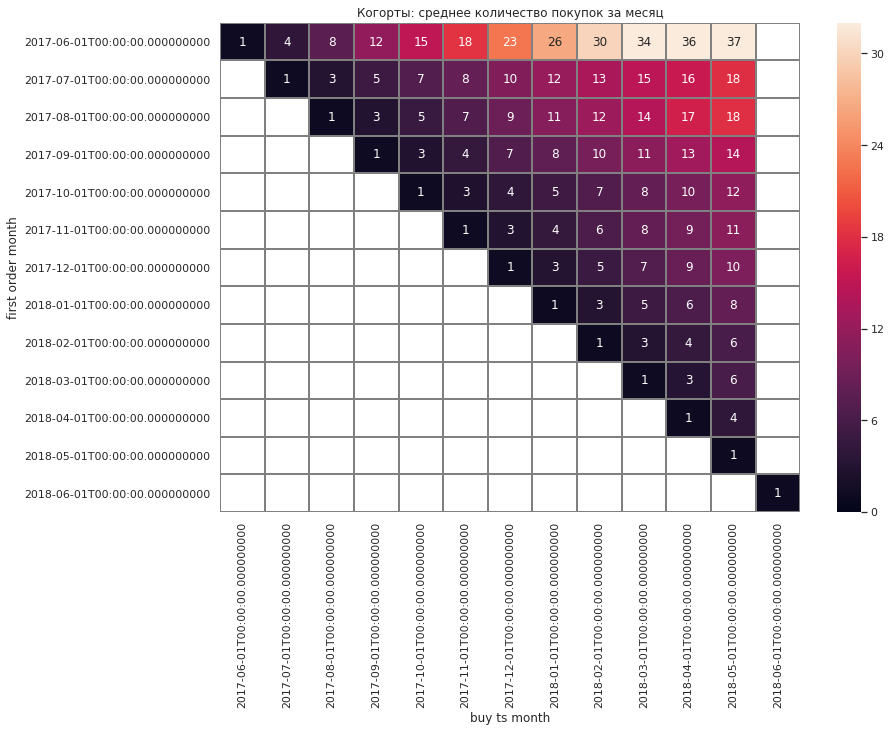

In [224]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Когорты: среднее количество покупок за месяц')
sns.heatmap(orders_cohorts_month_pivot,
    annot=True, fmt='.0f', linewidths=1, linecolor='gray',vmin=0, vmax=32);

В когорте 06-2017 самый высокий показатель повторных покупок, начиная с 4го месяца.

<a href='#step2'>Вверх</a><br>
<a id='step223'></a>
#### Какой средний чек?

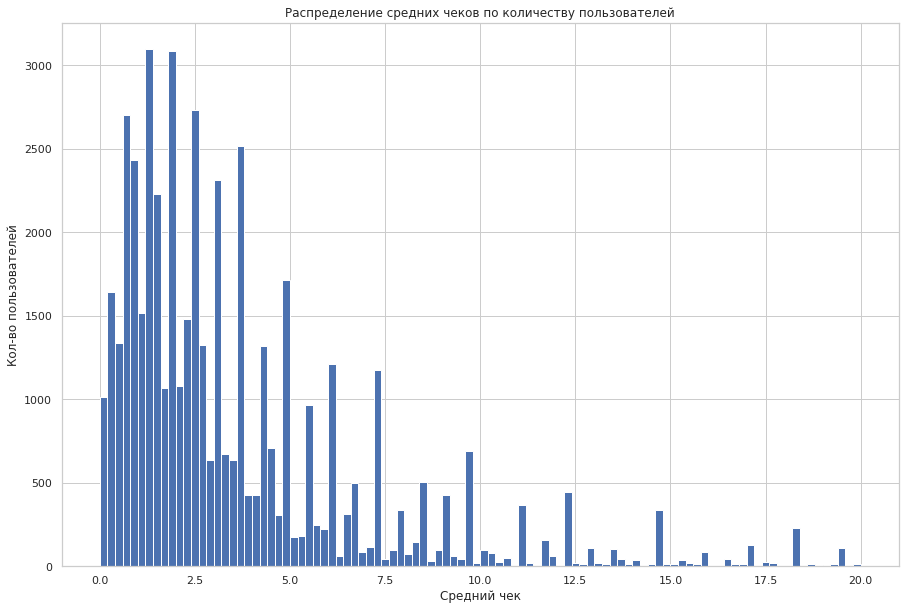

In [109]:
orders['revenue'].hist(figsize=(15, 10), range=(0, 20), bins=100)
#строю гистограмму распределения средних чеков
plt.ylabel('Кол-во пользователей')
plt.xlabel('Средний чек')
plt.title('Распределение средних чеков по количеству пользователей')
plt.show();

Согласно распределению на графике (не нормальное) необходимо использовать медианное значение.

In [110]:
print(
    'Средний чек: {:.1f}'.format(
    orders['revenue'].mean()))

Средний чек: 5.0


In [111]:
print(
    'Медианный чек: {:.1f}'.format(
    orders['revenue'].median()))

Медианный чек: 2.5


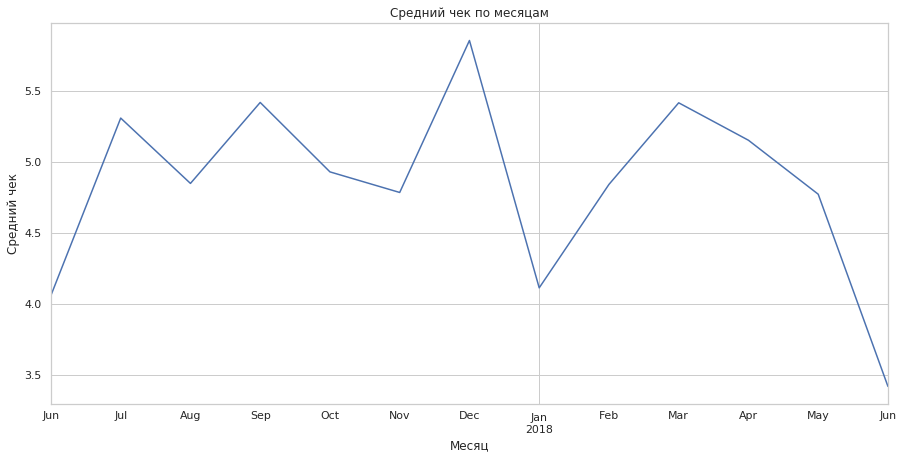

In [112]:
orders.groupby('buy ts month')['revenue'].mean().plot(figsize=(15, 7))
#строю график количества покупок по месяцам
#использую средний показатель (mean) т.к. в разбивке по месяцам выбросы нивелируются
plt.ylabel('Средний чек')
plt.xlabel('Месяц')
plt.title('Средний чек по месяцам')
plt.show()

Самый низкий средний чек в январе и июне.
Самый высокий в декабре, сентябре и марте.

In [113]:
orders_grouped_by_cohorts = orders.groupby(['first order month','buy ts month']).agg({'revenue':'sum','uid':'nunique'})

Группирую данные по когорте первого месяца покупки и месяцу совершения покупки

In [114]:
orders_grouped_by_cohorts['revenue per user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

Добавляю столбец со средним чеком покупателя.

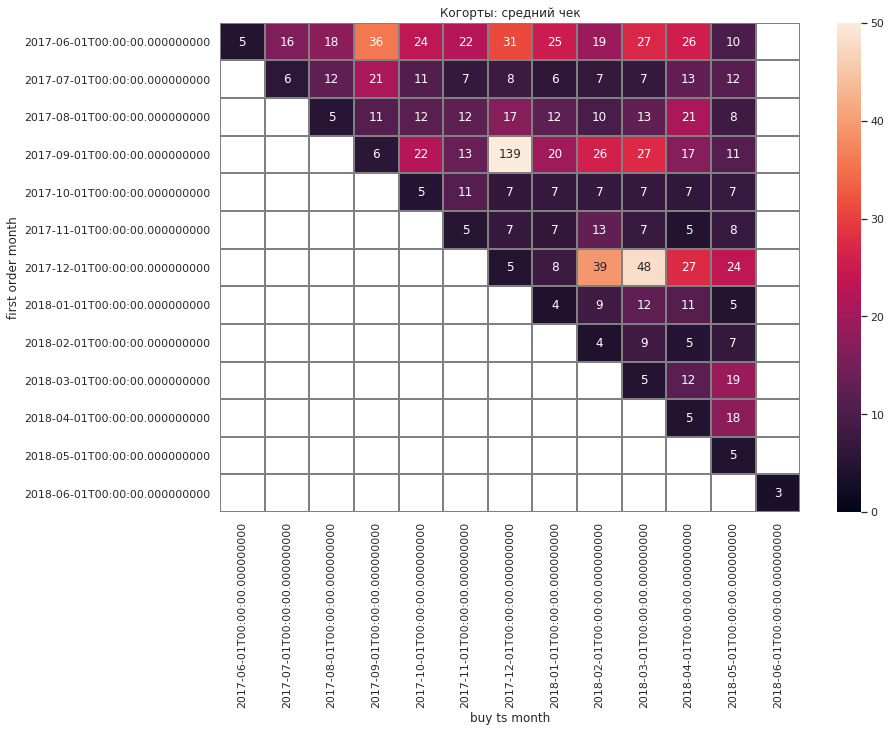

In [115]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Когорты: средний чек')
sns.heatmap(orders_grouped_by_cohorts.pivot_table(
    index='first order month',columns='buy ts month',values='revenue per user',aggfunc='mean'),
    annot=True, fmt='.0f', linewidths=1, linecolor='gray',vmin=0, vmax=50);

1. Средний чек на покупателя в декабре и марте самыйе высокие по большинству когорт.
2. Когорта 06.2017 наиболее стабильная по показателю среднего чека на покупателя.
3. Клиенты, которые совершили первую покупку в декабре, в дальнейшем демонстрируют самый высокий средний чек на пользователя.
4. Когорты, которые активны в декабре, в дальнейшем также показывают стабильно высокий средний чек.

<a href='#step2'>Вверх</a><br>
<a id='step224'></a>
#### Сколько денег приносят? (LTV)

Маржинальность не указана, далее для расчётов принимаю значение 90%.

In [116]:
user_first_source = visits.groupby('uid')['source id'].first().reset_index()

In [117]:
user_first_source = user_first_source.rename(columns={'source id':'first source'})

Формирую таблицу с информацией о источнике, с которого перешёл пользователь в свой первый визит и переименовываю соответствующую колонку.

In [118]:
display(user_first_source.head(15))

,uid,first source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
5,397399764396656,4
6,407573351275847,2
7,498809019029702,4
8,526778907996220,2
9,577434573913691,9


In [119]:
orders = orders.merge(user_first_source, on='uid', how='left')

Добавляю в датафрейм orders столбец с информацией о источнике, с которого пользователь совершил первый переход.

In [120]:
source_ltv = orders.groupby('first source').agg({'revenue':'sum','uid':'nunique'}).reset_index()

In [121]:
source_ltv['ltv'] = source_ltv['revenue']*0.9/source_ltv['uid']

Формирую таблицу с данными, сгруппированными по первому источнику, сумме выручки и количеству уникальных пользоваталей, рассчитываю LTV.

In [122]:
display(source_ltv)

,first source,revenue,uid,ltv
0,1,38560.06,3743,9.271722
1,2,65152.26,4323,13.563968
2,3,44317.68,9138,4.364840
3,4,52479.75,9823,4.808284
4,5,40357.91,6839,5.311028
5,7,1.22,1,1.098000
6,9,7076.98,1415,4.501259
7,10,4111.34,1241,2.981633


По источникам самый высокий LTV у 2 и 1 источника.<br>
Самый низкий у 5, 10 и 3.

In [123]:
cohort_sizes = orders.groupby('first order month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first order month', 'n buyers']


Формирую таблицу с количеством новых клиентов за каждый месяц.

In [124]:
cohorts_ltv = orders.groupby(['first order month','buy ts month']).agg({'revenue': 'sum'}).reset_index()

Формирую таблицу, сгруппированную по месяцу заказа и месяцу первого заказа клиента с расчётом количества уникальных клиентов.

In [125]:
cohorts_ltv = cohorts_ltv.merge(cohort_sizes, on='first order month', how='left')

Добавляю в ранее сформированную таблицу cohorts_ltv информацию о количестве новых клиентов в текущем месяце.

In [126]:
margin_rate = 0.9 #ранее принятый показатель
    
cohorts_ltv['gp'] = cohorts_ltv['revenue'] * margin_rate #рассчитываю валовую прибыль
cohorts_ltv['age'] = (cohorts_ltv['buy ts month'] - cohorts_ltv['first order month']) / np.timedelta64(1, 'M')
#рассчитываю возраст когорты
cohorts_ltv['age'] = cohorts_ltv['age'].round().astype('int')

Добавляю в таблицу информацию о валовой прибылт с ранее принятой маржинальностью 90% и возраст когорты.

In [127]:
cohorts_ltv['ltv'] = cohorts_ltv['gp'] / cohorts_ltv['n buyers']

In [128]:
display(cohorts_ltv.head())

,first order month,buy ts month,revenue,n buyers,gp,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,8601.741,0,4.251973
1,2017-06-01,2017-07-01,981.82,2023,883.638,1,0.436796
2,2017-06-01,2017-08-01,885.34,2023,796.806,2,0.393873
3,2017-06-01,2017-09-01,1931.30,2023,1738.170,3,0.859204
4,2017-06-01,2017-10-01,2068.58,2023,1861.722,4,0.920278


<a id='cltv'>
<a href='#step2'>Вверх</a><br>

Рассчитываю LTV по каждой строке.

In [129]:
cohorts_ltv_pivot = cohorts_ltv.pivot_table(
        index='first order month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')

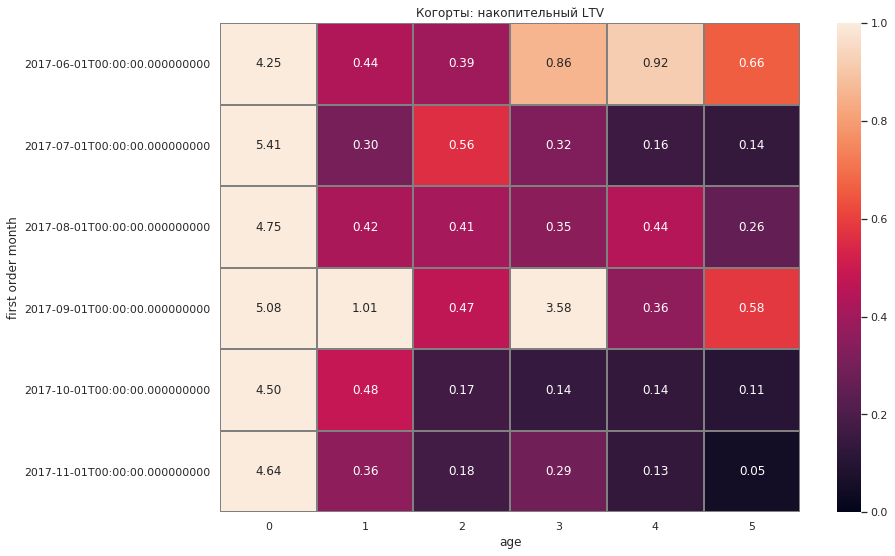

In [130]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Когорты: накопительный LTV')
sns.heatmap(cohorts_ltv_pivot.iloc[:6,:6], annot=True, fmt='.2f', linewidths=1, linecolor='gray',vmin=0, vmax=1);

При рассмотрении когорт, которые существуют как минимум 6 месяцев с результатом за первые 6 месяцев: клиенты из когорт: 06.2017, 09.2017 имеют самый высокий LTV по сравнению с остальными когортами.

In [131]:
print('Средний накопительный LTV по месяцам:')
display(cohorts_ltv_pivot.cumsum(axis=1).mean(axis=0));

Средний накопительный LTV по месяцам:


age
0      4.321514
1      4.856099
2      5.239630
3      6.020786
4      6.568771
5      7.172147
6      7.548918
7      8.175224
8      9.055875
9      8.326206
10     9.004154
11    10.691310
dtype: float64

In [132]:
print('Средний накопительный LTV по месяцам для первых 6 месяцев жизни когорт:')
display(cohorts_ltv_pivot.iloc[:6,:6].cumsum(axis=1).mean(axis=0));

Средний накопительный LTV по месяцам для первых 6 месяцев жизни когорт:


age
0    4.772114
1    5.273881
2    5.638611
3    6.563033
4    6.922059
5    7.221518
dtype: float64

<a href='#step2'>Вверх</a><br>
<a id='step225'></a>
### Вывод (Продажи)

##### Когда люди начинают покупать?
Медианное время первой покупки после первого взаимодействия: 0 дней, большинство пользователей совершает покупку в день первой активности.<br>

##### Сколько раз покупают за период?
Среднее количество покупок в день: 139 дней<br>
Среднее количество покупок в неделю: 951<br>
Среднее количество покупок в месяц: 3878<br>
<br>
По количеству покупок прослеживается сезонность с сентября по май, максимальное количество покупок за период в октябре-декабре, связано в том числе с новогодними прадниками.<br>

По когортам:<br>
В когорте 06-2017 самый высокий показатель повторных покупок, начиная с 4го месяца.<br>
В когортах с 09-2017 по 12-2017 также высокий показатель среднего числа повторных покупок на второй и третий месяц.

##### Какой средний чек?
Медианный чек: 2.5<br>
Средний чек: 5.0<br>
По типу распределения корректнее учитывать медианный чек.<br>

Самый низкий средний чек в январе и июне. В январе сказывается классическая просадка после новогодних праздников, в июне - завершается сезон театральных и концертных мероприятий.<br>
Самый высокий в декабре, сентябре и марте. В декабре сказываются новогодние праздники, в сентябре начала сезона. В марте может сказываться праздник 8 марта.<br>

Три группы клиентов, совершившие первые покупки в июне, сентябре и декабре 2017 в дальнейшем формируют стабильно высокий средний чек на одного пользователя.

##### Сколько денег приносят? (LTV)

По источникам самый высокий LTV у 2 и 1 источника.<br>
Самый низкий у 5, 10 и 3.<br>
При рассмотрении когорт, которые существуют как минимум 6 месяцев с результатом за первые 6 месяцев: клиенты из когорт: 06.2017, 09.2017 имеют самый высокий LTV по сравнению с остальными когортами.<br>
При этом клиенты из когорты 06.2017 могут быть постоянными клиентами, попавшими в статистику как первые из-за выбранного начала периода в отчете (06.2017).

Средний накопительный LTV по месяцам:<br>
0 месяцев:     4.32<br>
1 месяц:      4.85<br>
2 месяца:      5.23<br>
3 месяца:      6.02<br>
4 месяца:      6.56<br>
5 месяцев:      7.17<br>
6 месяцев:      7.54<br>
7 месяцев:      8.17<br>
8 месяцев:     9.05<br>
9 месяцев:      8.32<br>
10 месяцев:     9.00<br>
11 месяцев:    10.69<br>


<a href='#step2'>Вверх</a><br>
<a id='step23'></a>
### 2.3 Маркетинг

<a href='#step2'>Вверх</a><br>
<a id='step231'></a>
#### Сколько денег потратили всего?

In [133]:
print(
    'Всего потрачено на маркетинг: {:.0f}'.format(
    costs['costs'].sum()))

Всего потрачено на маркетинг: 329132


<a href='#step2'>Вверх</a><br>
<a id='step232'></a>
#### Сколько денег потратили на каждый источник?

In [134]:
costs_source = costs.groupby('source_id')['costs'].sum().reset_index()
#создаю таблицу с суммарными затратами по источнику
print('Потрачено на маркетинг по источникам:')
display(costs_source)

Потрачено на маркетинг по источникам:


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [135]:
print(visits_pm_device['users'])

0    16724
1     6825
Name: users, dtype: int64


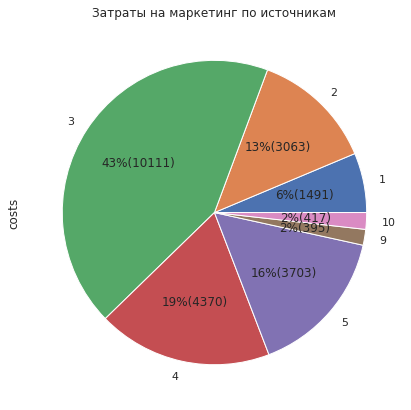

In [136]:
costs_source['costs'].plot(figsize = (7,7), legend=False, title='Затраты на маркетинг по источникам',
        kind='pie', labels=costs_source['source_id'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*visits_pm_device['users'].sum()));


Больше всего средств потрачено на источники: 3, 4 и 2.<br>
На источники 6,7 и 8 затраты не производились.

<a href='#step2'>Вверх</a><br>
<a id='step233'></a>
#### Сколько денег потратили по времени?

In [137]:
costs['dt month'] = costs['dt'].astype('datetime64[M]')

Добавляю столбец с месяцем затрат.

In [138]:
costs_month = costs.groupby('dt month')['costs'].sum().reset_index()
#создаю таблицу с суммарными затратами по источнику
print('Потрачено на маркетинг по месяцам:')
costs_month['dt month'] = costs_month['dt month'].astype(str)
display(costs_month)

Потрачено на маркетинг по месяцам:


,dt month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


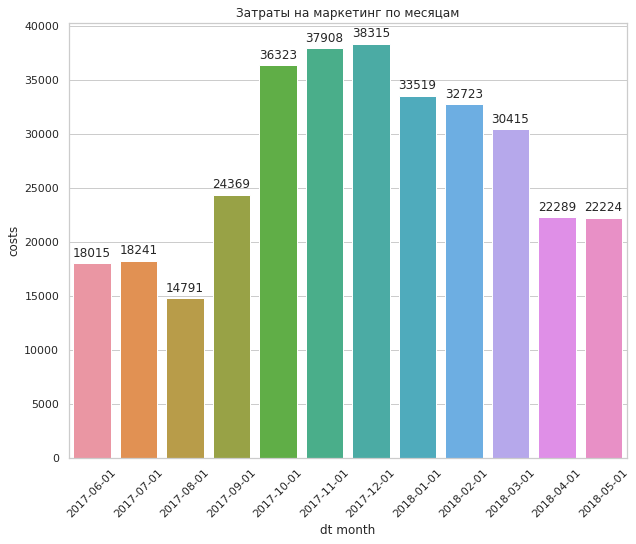

In [139]:
plt.figure(figsize=(10, 8)) #строю график
splot = sns.barplot(data=costs_month, x = 'dt month', y = 'costs', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
splot.set_xticklabels(splot.get_xticklabels(), rotation=45)
plt.title('Затраты на маркетинг по месяцам');

С сентября по март затраты выше, чем в остальные месяцы.<br>
В октябре - декабре затраты на маркетинг максимальные.


<a href='#step2'>Вверх</a><br>
<a id='step234'></a>
#### Сколько стоило привлечение одного покупателя из каждого источника?

In [140]:
costs_month_source = costs.groupby(['source_id','dt month'])['costs'].sum().reset_index()

Формирую таблицу суммарных затрат по месяцу и источнику трафика.

In [141]:
costs_month_source['key']= costs_month_source['source_id'].astype(str) + '-' + costs_month_source['dt month'].astype(str)

Формирую столбец с ключом для дальнейшего merge.

In [142]:
display(costs_month_source.head(15))

,source_id,dt month,costs,key
0,1,2017-06-01,1125.61,1-2017-06-01
1,1,2017-07-01,1072.88,1-2017-07-01
2,1,2017-08-01,951.81,1-2017-08-01
3,1,2017-09-01,1502.01,1-2017-09-01
4,1,2017-10-01,2315.75,1-2017-10-01
5,1,2017-11-01,2445.16,1-2017-11-01
6,1,2017-12-01,2341.20,1-2017-12-01
7,1,2018-01-01,2186.18,1-2018-01-01
8,1,2018-02-01,2204.48,1-2018-02-01
9,1,2018-03-01,1893.09,1-2018-03-01


Формирую таблицу с информацией о первом месяце, в котором пользователь сделал заказ.

In [143]:
users_month_source = orders.groupby(['first source','first order month'])['uid'].nunique().reset_index()

Формирую таблицу с количеством пользователей по источнику и месяцу первой покупки.

In [144]:
users_month_source['key'] = users_month_source ['first source'].astype(str) + '-' + users_month_source['first order month'].astype(str)

Формирую столбец с ключом для дальнейшего merge.

In [145]:
display(users_month_source.head(15))

,first source,first order month,uid,key
0,1,2017-06-01,203,1-2017-06-01
1,1,2017-07-01,211,1-2017-07-01
2,1,2017-08-01,145,1-2017-08-01
3,1,2017-09-01,283,1-2017-09-01
4,1,2017-10-01,409,1-2017-10-01
5,1,2017-11-01,452,1-2017-11-01
6,1,2017-12-01,458,1-2017-12-01
7,1,2018-01-01,337,1-2018-01-01
8,1,2018-02-01,345,1-2018-02-01
9,1,2018-03-01,348,1-2018-03-01


In [146]:
total = users_month_source.merge(costs_month_source, on='key', how='left')

Формирую итоговую таблицу для расчёта CAC

In [147]:
total['cac'] = total['costs']/total['uid']

In [148]:
display(total.head())

,first source,first order month,uid,key,source_id,dt month,costs,cac
0,1,2017-06-01,203,1-2017-06-01,1.0,2017-06-01,1125.61,5.544877
1,1,2017-07-01,211,1-2017-07-01,1.0,2017-07-01,1072.88,5.084739
2,1,2017-08-01,145,1-2017-08-01,1.0,2017-08-01,951.81,6.564207
3,1,2017-09-01,283,1-2017-09-01,1.0,2017-09-01,1502.01,5.307456
4,1,2017-10-01,409,1-2017-10-01,1.0,2017-10-01,2315.75,5.661980


In [149]:
display(total.groupby('first source')['cac'].mean().reset_index())
#вывожу данные с средним САС по источникам

,first source,cac
0,1,5.600034
1,2,10.087368
2,3,15.884857
3,4,6.687370
4,5,7.553257
5,7,NaN
6,9,4.301936
7,10,5.259864


Самое дорогое привлечение одного клиента в источниках 2 и 3.

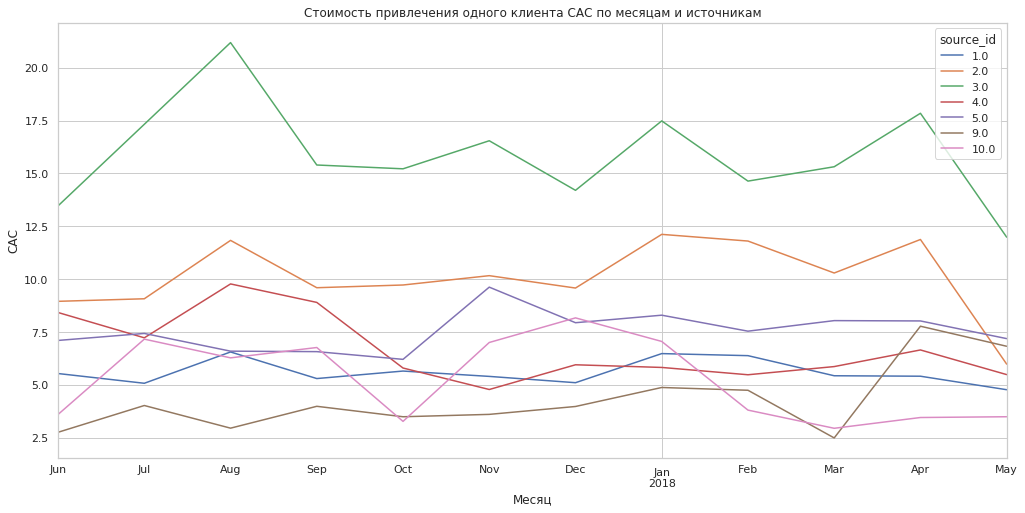

In [150]:
total.pivot_table(index='dt month',columns = 'source_id', values='cac').plot(figsize = (17,8))
plt.ylabel('CAC')
plt.xlabel('Месяц')
plt.title('Стоимость привлечения одного клиента CAC по месяцам и источникам')
plt.show()

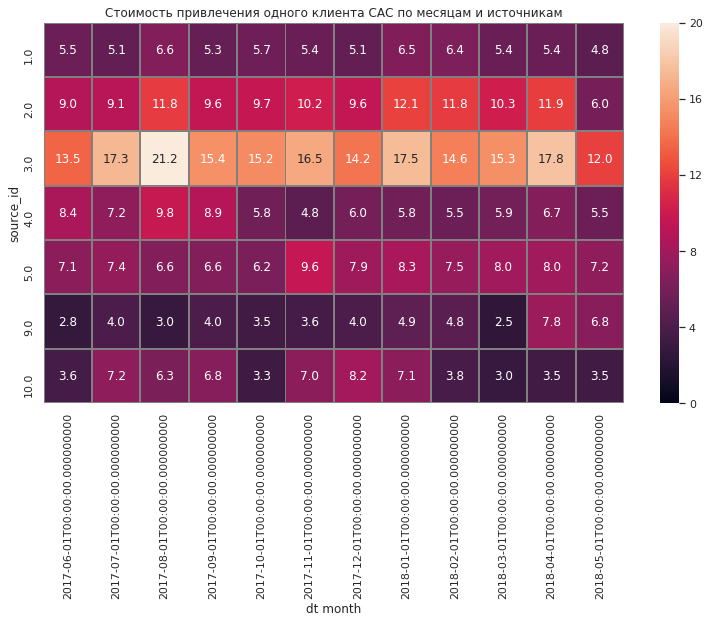

In [151]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 7))
plt.title('Стоимость привлечения одного клиента CAC по месяцам и источникам')
sns.heatmap(total.pivot_table(
    index='dt month',columns = 'source_id', values='cac').T,
    annot=True, fmt='.1F', linewidths=1, linecolor='gray',vmin=0, vmax=20);

Для источников 3 и 2 самые дорогие месяцы для привлечения клиентов: август, январь, апрель.<br>
Также для источников 1 и 4 самый дорогой месяц: август.<br>
Для источника 5 - ноябрь, 10 - декабрь. 

<a href='#step2'>Вверх</a><br>
<a id='step235'></a>
#### На сколько окупились расходы? (ROI)

In [152]:
total_romi = (orders['revenue'].sum()*0.9/costs['costs'].sum())
print('Общий ROMI по проекту: {:.1%}'.format(total_romi))

Общий ROMI по проекту: 68.9%


<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ ОТ УЧЕНИКА:</b><br>
Решил добавить общий ROMI про проекту.
</div>

In [153]:
display(costs)

,source_id,dt,costs,dt month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [154]:
revenue_month_source = orders.groupby(['first source','first order month'])['revenue'].sum().reset_index()

Формирую таблицу с выручкой по первому источнику и месяцу первой покупки.

In [155]:
revenue_month_source['key']=revenue_month_source['first source'].astype(
    str) + '-' + revenue_month_source['first order month'].astype(str)

Формирую столбец с ключом для дальнейшего merge.

In [156]:
total = total.merge(revenue_month_source[['key','revenue']], on='key',how='left')

Добавляю в таблицу total выручку первому по источнику и месяцу первой покупки.

In [157]:
total['romi'] = (total['revenue']*0.9/total['costs']) #ранее принята маржинальность 90%

In [158]:
display(total.head())

,first source,first order month,uid,key,source_id,dt month,costs,cac,revenue,romi
0,1,2017-06-01,203,1-2017-06-01,1.0,2017-06-01,1125.61,5.544877,7022.25,5.614756
1,1,2017-07-01,211,1-2017-07-01,1.0,2017-07-01,1072.88,5.084739,3651.29,3.062934
2,1,2017-08-01,145,1-2017-08-01,1.0,2017-08-01,951.81,6.564207,1279.94,1.210269
3,1,2017-09-01,283,1-2017-09-01,1.0,2017-09-01,1502.01,5.307456,4478.11,2.683270
4,1,2017-10-01,409,1-2017-10-01,1.0,2017-10-01,2315.75,5.661980,3598.97,1.398714


In [159]:
display(total.groupby('source_id')['romi'].mean().reset_index())

,source_id,romi
0,1.0,1.872245
1,2.0,1.425658
2,3.0,0.283208
3,4.0,0.778158
4,5.0,0.764015
5,9.0,1.274330
6,10.0,0.646677


Вывожу средний ROMI по месяцам.

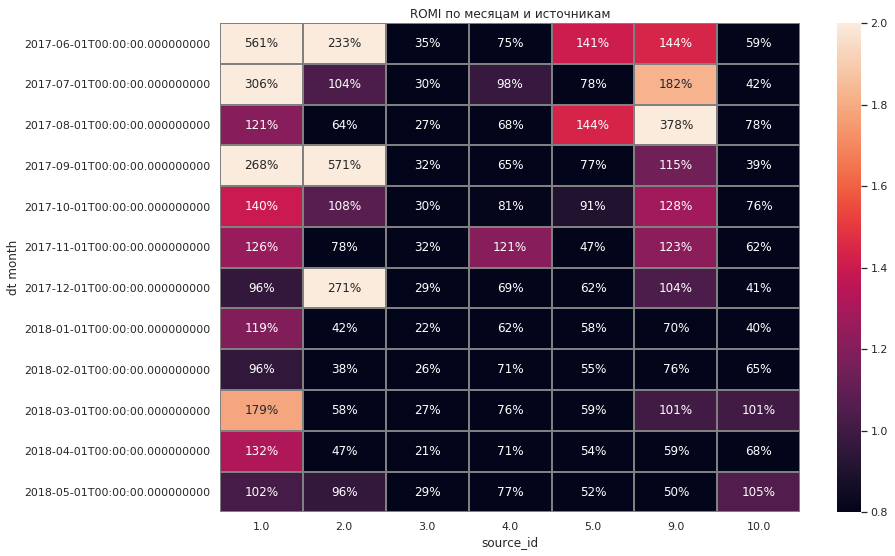

In [160]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('ROMI по месяцам и источникам')
sns.heatmap(total.pivot_table(index='dt month',columns = 'source_id', values='romi'),
    annot=True, fmt='.0%', linewidths=1, linecolor='gray',vmin=0.8, vmax=2);

Источники с самым высоким ROMI: 1, 2, 9.<br>
Самый низкий ROMI у 3 источника.<br>
Месяц, в котором ROMI был самым высоким: июнь 2017, сентябрть 2017.<br>
Самый низкий: февраль 2018.<br>

In [161]:
monthly_costs = costs.groupby('dt month').sum()
monthly_costs.head()

,source_id,costs
dt month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88


Формирую таблицу с сгруппированными даннами о затратах по месяцам.

In [162]:
cohorts_romi = pd.merge(cohorts_ltv, monthly_costs, left_on='first order month', right_on='dt month')

Формирую на основе таблицы <a href='#cltv'>cohorts_ltv</a> таблицу, в которую также добавляю данные о затратах по месяцам.
<a id='back'></a>

In [163]:
cohorts_romi['cac'] = cohorts_romi['costs'] / cohorts_romi['n buyers']

Добавляю столбец с расчётом САС.

In [164]:
cohorts_romi['romi'] = cohorts_romi['ltv'] / cohorts_romi['cac']

In [165]:
output = cohorts_romi.pivot_table(
        index='first order month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

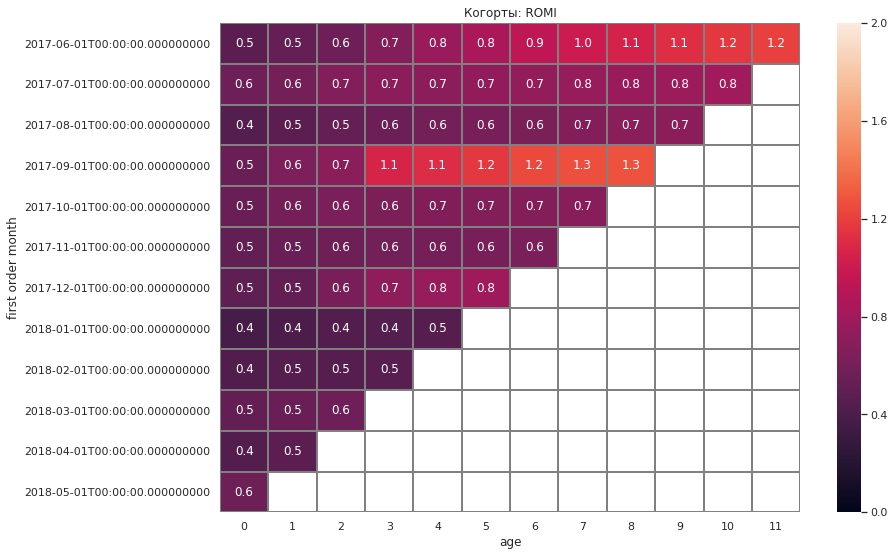

In [166]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Когорты: ROMI')
sns.heatmap(output.cumsum(axis=1).round(2), annot=True, fmt='.1f', linewidths=1, linecolor='gray',vmin=0, vmax=2);

Сентябрьская когорта окупается быстрее всего.<br>
По динамике декабрьская когорта схожа с июньской (2017) и, вероятно, окупится на 7-8 месяц жизни.

In [167]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.486734
1     0.523786
2     0.567962
3     0.647766
4     0.704652
5     0.773888
6     0.807137
7     0.872956
8     0.948484
9     0.868039
10    0.985192
11    1.200584
dtype: float64

В среднем когорты окупаются к концу 11го месяца.

<a href='#step2'>Вверх</a><br>
<a id='step236'></a>
### Вывод (Маркетинг)

##### Сколько денег потратили всего?
Всего потрачено на маркетинг: 329132

##### Сколько денег потратили на каждый источник?
<table>
    <table align="left">
	<tbody>
		<tr>
			<td>Источник</td>
			<td>Затраты</td>
		</tr>
		<tr>
			<td>1</td>
			<td>20833</td>
		</tr>
		<tr>
			<td>2</td>
			<td>42806</td>
		</tr>
		<tr>
			<td>3</td>
			<td>141321</td>
		</tr>
		<tr>
			<td>4</td>
			<td>61073</td>
		</tr>
		<tr>
			<td>5</td>
			<td>51757</td>
		</tr>
		<tr>
			<td>9</td>
			<td>5517</td>
		</tr>
		<tr>
			<td>10</td>
			<td>5822</td>
		</tr>
	</tbody>
</table>

Больше всего средств потрачено на источники: 3, 4 и 2.<br>
На источники 6,7 и 8 затраты не производились.

##### Сколько денег потратили по времени?
<table>
    <table align="left">
	<tbody>
		<tr>
			<td>Месяц</td>
			<td>Затраты</td>
		</tr>
		<tr>
			<td>06.2017</td>
			<td>18015</td>
		</tr>
		<tr>
			<td>07.2017</td>
			<td>18241</td>
		</tr>
		<tr>
			<td>08.2017</td>
			<td>14791</td>
		</tr>
		<tr>
			<td>09.2017</td>
			<td>24369</td>
		</tr>
		<tr>
			<td>10.2017</td>
			<td>36323</td>
		</tr>
		<tr>
			<td>11.2017</td>
			<td>37908</td>
		</tr>
		<tr>
			<td>12.2017</td>
			<td>38315</td>
		</tr>
		<tr>
			<td>01.2018</td>
			<td>33519</td>
		</tr>
		<tr>
			<td>02.2018</td>
			<td>32723</td>
		</tr>
        <tr>
			<td>03.2018</td>
			<td>30415</td>
		</tr>
        <tr>
			<td>04.2018</td>
			<td>22289</td>
		</tr>
        <tr>
			<td>05.2018</td>
			<td>22224</td>
		</tr>
	</tbody>
</table>

С сентября по март затраты выше, чем в остальные месяцы.<br>
В октябре - декабре затраты на маркетинг максимальные.

##### Сколько стоило привлечение одного покупателя из каждого источника?
<table align="left">
	<tbody>
		<tr>
			<td>Источник</td>
			<td>Затраты</td>
		</tr>
		<tr>
			<td>1</td>
			<td>5.6</td>
		</tr>
		<tr>
			<td>2</td>
			<td>10.1</td>
		</tr>
		<tr>
			<td>3</td>
			<td>15.8</td>
		</tr>
		<tr>
			<td>4</td>
			<td>6.7</td>
		</tr>
		<tr>
			<td>5</td>
			<td>7.6</td>
		</tr>
		<tr>
			<td>9</td>
			<td>4.3</td>
		</tr>
		<tr>
			<td>10</td>
			<td>5.3</td>
		</tr>
	</tbody>
</table>


Самое дорогое привлечение одного клиента в источниках 2 и 3.<br>
Для источников 3 и 2 самые дорогие месяцы для привлечения клиентов: август, январь, апрель.<br>
Также для источников 1 и 4 самый дорогой месяц: август.<br>
Для источника 5 - ноябрь, 10 - декабрь.

##### На сколько окупились расходы? (ROMI)

Маржинальность проекта явно не указана и принята мной за 90%.<br>
Общий ROMI по проекту: 68.9%<br>
Проект не окупился за год.<br>

По источникам:
<ul>
 <li>Источники с положительным ROMI: 1, 2, 9</li>
 <li>Катастрофический низкий ROMI у 3 источника</li>
 <li>Месяц, в котором ROMI был самым высоким: июнь 2017, сентябрь 2017</li>
 <li>Месяц, в котором ROMI был самым низким: февраль 2018</li>
</ul>

По когортам:
<ul>
 <li>В среднем когорты окупаются к концу 11го месяца</li>
 <li>Катастрофический низкий ROMI у 3 источника, 28%</li>
 <li>Сентябрьская когорта окупается быстрее всего</li>
 <li>По динамике декабрьская когорта схожа с июньской (2017) и, вероятно, окупится на 7-8 месяц жизни</li>
</ul>

<a id='step3'></a>
## Шаг 3. Вывод с рекомендацией маркетологам, куда и сколько им стоит вкладывать денег


#### Рекомендация №1
Повысить количество пользователей с устройств типа touch.<br>
По данным hootsuite.com https://www.web-canape.ru/files/352/share-of-web-traffic-by-d.png на desktop девайсы приходится примерно 50% интернет трафика.<br>
В нашем случае, 28% с устройств типа touch - недостаточный показатель.<br>

На устройствах touch сессия в два раза короче, чем на desktop. Соответственно, необходимо также проверить корректную работу интерфейса, предназначенного для мобильных touch устройств.

#### Рекомендация №2

Сезонность бизнеса: с сентября по май.<br>
Необходимо учитывать старт сезона (сентябрь), новогодний рост продаж (декабрь), а также рост среднего чека в марте (вероятно связанный с праздником 8 марта).<br>

Исходя из когортного анализа лучшие месяцы для старта агрессивных рекламных компаний: сентябрь, декабрь.<br>
В несезон также необходимо продолжать рекламные компании, но с пониженным бюджетом.<br>

Также необходима стратегия по формированию пула удержанию постоянных клиентов (когорты июня 2017 демонстрируют стабильные показатели, вероятно,  это постоянные клиенты).


#### Рекомендация №3
Сводная таблица по источникам:
<table align="left">
	<tbody>
		<tr>
			<td>Источник</td>
			<td>MAU, доля</td>
			<td>Длительность сессии, сек</td>
			<td>Затраты на маркетинг, доля</td>
			<td>САС</td>
			<td>ROMI</td>
			<td>LTV</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>1</td>
			<td>7%</td>
			<td>1039</td>
			<td>6%</td>
			<td>6</td>
			<td>9</td>
			<td>1.9</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>2</td>
			<td>11%</td>
			<td>844</td>
			<td>13%</td>
			<td>10</td>
			<td>14</td>
			<td>1.4</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>3</td>
			<td>26%</td>
			<td>572</td>
			<td>43%</td>
			<td>16</td>
			<td>4</td>
			<td>0.3</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>4</td>
			<td>30%</td>
			<td>559</td>
			<td>19%</td>
			<td>7</td>
			<td>5</td>
			<td>0.8</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>5</td>
			<td>19%</td>
			<td>526</td>
			<td>16%</td>
			<td>8</td>
			<td>5</td>
			<td>0.8</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>9</td>
			<td>4%</td>
			<td>566</td>
			<td>2%</td>
			<td>4</td>
			<td>5</td>
			<td>1.3</td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>10</td>
			<td>3%</td>
			<td>662</td>
			<td>2%</td>
			<td>5</td>
			<td>3</td>
			<td>0.7</td>
			<td></td>
			<td></td>
		</tr>
	</tbody>
</table>


1. Отказ от источника 3. Очень низкий ROMI, который на растёт во времени.
2. Увеличение бюджета на источники 1, 2 и 9, необходимо привлечение клиентов и рост MAU (DAU, WAU). В источнике 9 короткая длительность сессии, небходимо проверить поведение пользователей и удобство интерфейса.
3. Источники 4 и 5 имеют большую долю пользоваталей, однако ROMI отрицательный, близкий к 1. Соответственно необходимо провести дополнительные исследования, чтобы понять, как вывести эти источники в плюс. Исходя из имеющихся данных - также необходимо проверить интерфейс, т.к. источники имеют короткое время сессии.